# NYC Taxi Trip Duration (Kaggle Competition)
---
## 1. Understanding the Problem

* **Project Goal**: building a regression model to predict the total travel time of taxi trips in New York City. 
* **Personal Goal**: Reach the top 10% of the competition... as of Sept 12th, I am sitting at 86th out of 1185 teams (top 8%) on the [Public LB](https://www.kaggle.com/c/nyc-taxi-trip-duration/leaderboard) :)
* **Data**: 1.5 million yellow cab rides released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables
* **Metric**: Root Mean Squared Logarithmic Error (RMSLE)

In [21]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
plt.rcParams['figure.figsize'] = [16, 10]

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression, SGDRegressor, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR

## 2. Load Data

In [22]:
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv')
wdf = pd.read_csv("../input/weather-data-in-new-york-city-2016/weather_data_nyc_centralpark_2016.csv")

In [23]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


**Features**

* **id** - a unique identifier for each trip
* **vendor_id** - a code indicating the provider associated with the trip record
* **pickup_datetime** - date and time when the meter was engaged
* **dropoff_datetime** - date and time when the meter was disengaged
* **passenger_count** - the number of passengers in the vehicle (driver entered value)
* **pickup_longitude** - the longitude where the meter was engaged
* **pickup_latitude** - the latitude where the meter was engaged
* **dropoff_longitude** - the longitude where the meter was disengaged
* **dropoff_latitude** - the latitude where the meter was disengaged
* **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* **trip_duration** - duration of the trip in seconds, **target variable**

### Optimize dtypes

In [24]:
print('DataFrame Info: ---------------------')
train.info()

DataFrame Info: ---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [25]:
# Optimize dtypes (for speeding up computuations later)
train.store_and_fwd_flag = train.store_and_fwd_flag.astype('category')
train.passenger_count = train.passenger_count.astype(np.uint8)
train.vendor_id = train.vendor_id.astype(np.uint8)
train.trip_duration = train.trip_duration.astype(np.uint32)
for c in [c for c in train.columns if c.endswith('tude')]:
    train.loc[:, c] = train[c].astype(np.float32)

In [26]:
# Converting original datetime columns to pandas datetime series
train.pickup_datetime = pd.to_datetime(train.pickup_datetime)
test.pickup_datetime = pd.to_datetime(test.pickup_datetime)
train.dropoff_datetime = pd.to_datetime(train.dropoff_datetime)

In [27]:
print('Train set Memory usage (optimized), Mb: {:.2f}'.format(train.memory_usage().sum()/2**20))

Train set Memory usage (optimized), Mb: 65.38


- Memory usage has decreased by 50%
- This will speed up the XGBoost models later
- **Edit**: This was a good idea to start but I realized I extracted bunch of new features throughout this notebook so I will need to reoptimize the features later right before running the model

## 3. Check Data

### 3.1 Missing values

In [28]:
# In Python 3.6 you can execute if/else statements on one line!
print("No need to deal with missing values :)") if sum(train.isnull().sum()) == 0 and \
sum(test.isnull().sum()) == 0 else print("We need to deal with missing values :/")

No need to deal with missing values :)


### 3.2 Sanity Checks

In [29]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [30]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [31]:
print("There are {} training rows and {} test rows".format(len(train),len(test)))
print("There are {} training columns and {} test columns".format(len(train.columns),len(test.columns)))

There are 1458644 training rows and 625134 test rows
There are 11 training columns and 9 test columns


In [32]:
print("Columns not in test set: {}".format([col for col in train.columns if col not in test.columns]))

Columns not in test set: ['dropoff_datetime', 'trip_duration']


- Note that `trip_duration` is excluded from the test set because this is the **target variable** we are trying to predict
- `dropoff_datetime` is also excluded from the test set because if it was included we could easily calculate the trip duration in seconds by subtracting dropoff datetime from pickup datetime and would make our task trivial!
- Next up: making sure that our data makes sense

In [33]:
# Check for duplicate ids
print('No of Duplicates, Trip IDs: {}'.format(len(train) - len(train.drop_duplicates(subset='id'))))

# Check trip duration range
print('Trip duration in seconds: {} to {}'.format(train.trip_duration.min(), train.trip_duration.max()))

# Check datetime range
print("Datetime range: {} to {}".format(train.pickup_datetime.min(), train.dropoff_datetime.max()))

# Check passenger count range
print('Passengers: {} to {}'.format(train.passenger_count.min(), train.passenger_count.max()))

No of Duplicates, Trip IDs: 0
Trip duration in seconds: 1 to 3526282
Datetime range: 2016-01-01 00:00:17 to 2016-07-01 23:02:03
Passengers: 0 to 9


- Couple of things to notice here:
    - No duplicate trip ids... nice
    - Someone took a 1 second taxi ride?? They must have mastered the power of quantum teleportation! (0__0)
        - Also someone was on the road for 3,526,282 seconds which is approximately 40 days. Cross country trip??
        - These trips are outliers and I will consider removing them in the next section
    - Trips range from January 1st, 2016 to July 1st, 2016 --> 6 months of data
    - There is a passenger count of 0? I guess the taxi driver likes turning on the meter when he's driving around by himself...
        - There's also a passenger count of 9... must be one big taxi
    - Anyways, we'll keep these in for now
    - Next up: Feature extraction

##  4. Feature Extraction

I think three of the most important features for predicting trip duration will be:

1. the trip distance (further distance = longer travel time)
2. the pickup time (times around rush hour should cause longer travel time)
3. inclement weather (snow or rain should increase travel time)

Intuitively, these seem like the best features to predict trip duration but the good news is that **XGBoost** does not care about irrelevant information so even if adding a feature will decrease our error by a tiny bit, we should still include it. In reality we prefer simpler models, but I am trying to get the best score on Kaggle which requires smart feature engineering and the inclusion of many features. Also XGBoost doesn't care about multicolliearity so in theory we can throw in as many features as we want. Another cool thing about XGBoost is that it doesn't care about missing values which will save us some headaches.

- Lets start by applying PCA to the latitude/ longitude coordinates and then extracting features from them

### 4.1 PCA

- Credit to the user [beluga](https://www.kaggle.com/gaborfodor) on Kaggle for this version of PCA.
- Here we are using PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since we are transforming from 2D to 2D. Instead, we are preserving as much variation as possible in the first component and the rest in the second component which will help model performance later on.

In [34]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [35]:
pca.explained_variance_ratio_

array([ 0.81757063,  0.18242937])

In [36]:
pca.components_

array([[-0.05865096, -0.99827855],
       [ 0.99827855, -0.05865096]])

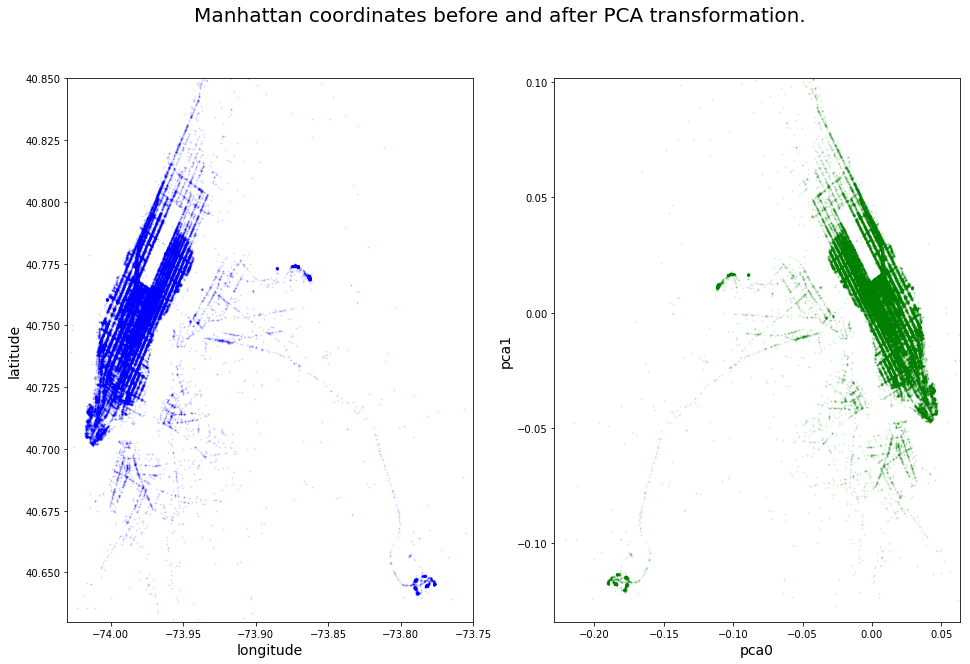

In [37]:
N = 100000 # Only select a sample of 100k points to plot
fig, ax = plt.subplots(ncols=2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N], color='green', s=1, alpha=0.1)
fig.suptitle('Manhattan coordinates before and after PCA transformation.', fontsize=20)
ax[0].set_ylabel('latitude', fontsize=14)
ax[0].set_xlabel('longitude', fontsize=14)
ax[1].set_xlabel('pca0', fontsize=14)
ax[1].set_ylabel('pca1', fontsize=14)
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

- Notice that not much has changed besides:
    - Data centered at (0,0) which is essentially normalization
    - Points are inverted
    - 5 degree rotation
- This step was probably not necessary but will give a small performance boost in the end
- Next up: extracting distance

### 4.2 Distance

These distance functions are also from the user [beluga](https://www.kaggle.com/gaborfodor) on Kaggle. I tried to make these myself but ended up finding these super helpful functions while looking over his kernel. There are 3 types of distances extracted here:
 1. **Haversine distance**: the great-circle distance between two coordinates, which takes into account the curvature of the Earth in computing the distance.
 2. **Manhattan distance**: We are analyzing Manhattan coordinates so we can look at the usual L1 distance which uses haversine distance as an input
 3. **Bearing**: The direction of the trip using radians as a unit

- Here's more info regarding the [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula),  [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) and [bearing](http://www.movable-type.co.uk/scripts/latlong.html) formulas

In [38]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [39]:
# Get distance features for train and test set

train['distance_haversine'] = haversine_array(train['pickup_latitude'].values, 
                                              train['pickup_longitude'].values, 
                                              train['dropoff_latitude'].values, 
                                              train['dropoff_longitude'].values)

train['distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, 
                                                             train['pickup_longitude'].values, 
                                                             train['dropoff_latitude'].values, 
                                                             train['dropoff_longitude'].values)

train['direction'] = bearing_array(train['pickup_latitude'].values, 
                                   train['pickup_longitude'].values, 
                                   train['dropoff_latitude'].values, 
                                   train['dropoff_longitude'].values)

train['pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test['distance_haversine'] = haversine_array(test['pickup_latitude'].values,
                                             test['pickup_longitude'].values, 
                                             test['dropoff_latitude'].values, 
                                             test['dropoff_longitude'].values)

test['distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values,
                                                            test['pickup_longitude'].values, 
                                                            test['dropoff_latitude'].values,
                                                            test['dropoff_longitude'].values)

test['direction'] = bearing_array(test['pickup_latitude'].values,
                                  test['pickup_longitude'].values, 
                                  test['dropoff_latitude'].values, 
                                  test['dropoff_longitude'].values)

test['pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train['center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train['center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test['center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test['center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

### 4.3 Datetime

- Next, let's extract as many datetime features as we can using the `.dt` attribute

In [40]:
# Get dt features for train and test set
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_weekday_name'] = train['pickup_datetime'].dt.weekday_name
train['pickup_hour_dayofyear'] = train['pickup_datetime'].dt.dayofyear
train['pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_weekday_name'] = test['pickup_datetime'].dt.weekday_name
test['pickup_hour_dayofyear'] = test['pickup_datetime'].dt.dayofyear
test['pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + train['pickup_hour']

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 31 columns):
id                          1458644 non-null object
vendor_id                   1458644 non-null uint8
pickup_datetime             1458644 non-null datetime64[ns]
dropoff_datetime            1458644 non-null datetime64[ns]
passenger_count             1458644 non-null uint8
pickup_longitude            1458644 non-null float32
pickup_latitude             1458644 non-null float32
dropoff_longitude           1458644 non-null float32
dropoff_latitude            1458644 non-null float32
store_and_fwd_flag          1458644 non-null category
trip_duration               1458644 non-null uint32
pickup_pca0                 1458644 non-null float64
pickup_pca1                 1458644 non-null float64
dropoff_pca0                1458644 non-null float64
dropoff_pca1                1458644 non-null float64
distance_haversine          1458644 non-null float32
distance_dummy_manhattan    14

### 4.4 Speed

- Remember that the only data we were given at the beginning were latitude/longitude coordinates, pickup/dropoff dates and trip duration. From there we extracted distance and datetime features. Next comes the really cool part of this analysis.  

- Any high school physics student would tell you that
$$ \text{speed} = \frac{\text{distance}}{\text{time}} $$

- Now we are able extract average speed. This project is turning into an analysis of traffic patterns in Manhattan. There is a lot of useful information to be gained here and the best way to go about it is through visualization which is coming up in the next section.

In [42]:
# Extracting haversine and manhattan speed
train['avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train['avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

- Note that the difference between these two notions of speed is pretty trivial but we will use Haversine speed because it is techincally the correct way of peforming the calculation

### 4.5 Traffic Patterns

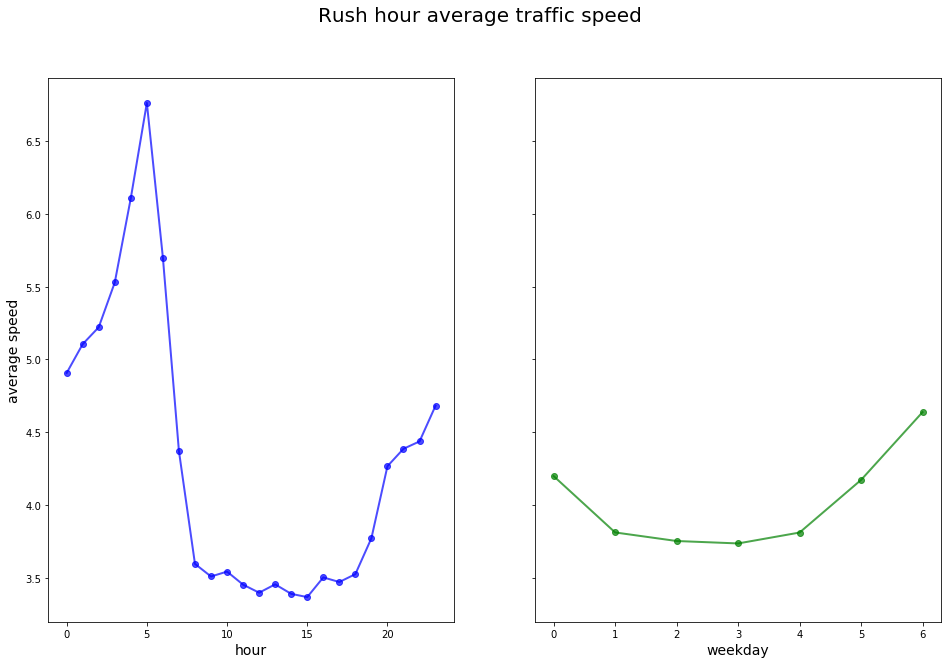

In [43]:
# Plot average speed vs. hour and weekday
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour', fontsize=14)
ax[1].set_xlabel('weekday', fontsize=14)
ax[0].set_ylabel('average speed', fontsize=14)
fig.suptitle('Rush hour average traffic speed', fontsize=20)
plt.show()

### 4.6 Traffic Hotspots

- Now let's take a look at where traffic tends to build up in Manhattan.
- This is performed by using the counts of `id` trips of a taxi ride and binning them into different areas around the city
- **Note**: This is a really cool plot I found on Kaggle that I wanted to include but to be honest I'm still wrapping my head around how it makes the heatmap. I do understand that it makes a count of id's and then uses these counts plus average speed in each area to figure out how much traffic is present

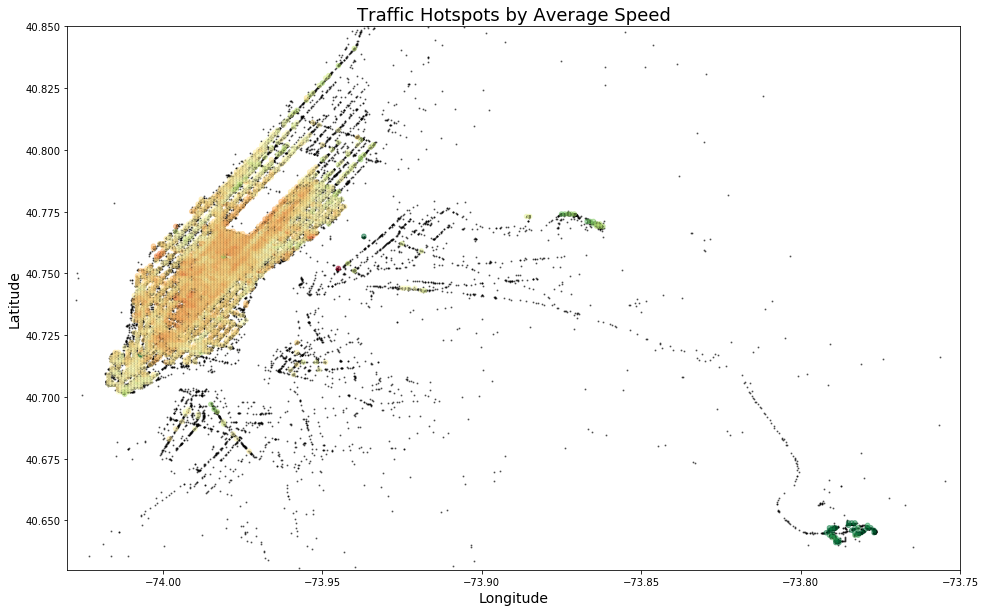

In [44]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title('Traffic Hotspots by Average Speed', fontsize=18)
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

We can see that there is the most traffic in Midtown and the Upper East Side of Manhattan. Also there is a good amount of traffic coming in and out of LaGuardia and JFK airports.

### 4.7 Check test/train split

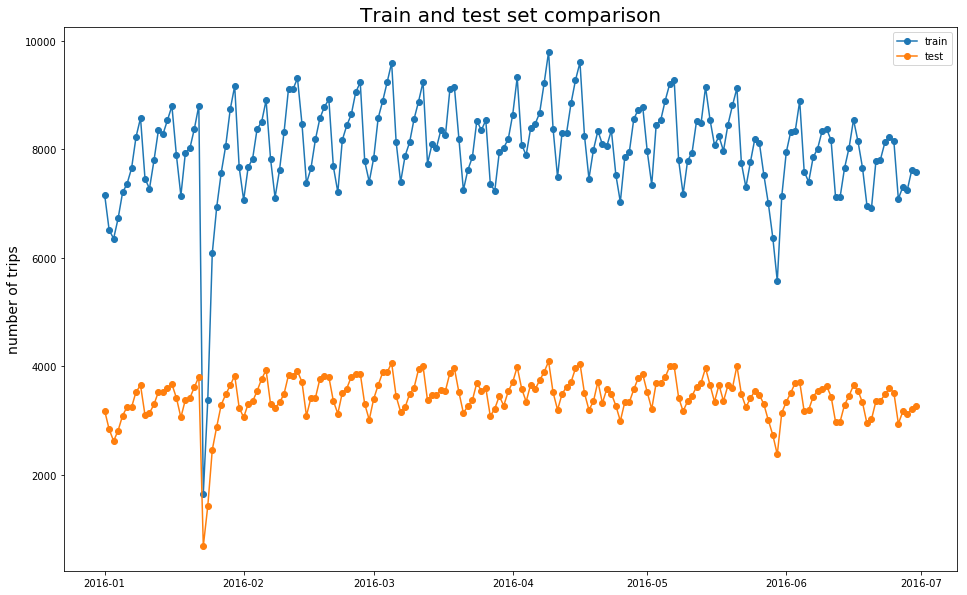

In [45]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test set comparison', fontsize=20)
plt.legend(loc=0)
plt.ylabel('number of trips', fontsize=14)
plt.show()

* Things to notice:
    - Huge drop in taxi trips in late January
        - Not sure why this is the case. Probably weather related or a mistake in data collection.
    - Also a pretty big drop at the end of May. Maybe people leave the city for Memorial Day Weekend and don't end up taking taxis?
    - Need to explore this question further

### 4.8 Weather

In [46]:
wdf.date = pd.to_datetime(wdf.date)

In [47]:
wdf.head()

,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-02-01,40,32,36.0,0.00,0.0,0
2,2016-03-01,45,35,40.0,0.00,0.0,0
3,2016-04-01,36,14,25.0,0.00,0.0,0
4,2016-05-01,29,11,20.0,0.00,0.0,0


In [48]:
wdf.dtypes

date                   datetime64[ns]
maximum temerature              int64
minimum temperature             int64
average temperature           float64
precipitation                  object
snow fall                      object
snow depth                     object
dtype: object

In [49]:
falls = [ 0.25 if c=='T' else float(c) for c in wdf['snow fall']]
rain = [ 0.25 if c=='T' else float(c) for c in wdf['precipitation']]
wdf['snow fall']= falls
wdf['precipitation'] = rain
wdf['pickup_hour_dayofyear'] = wdf.date.dt.dayofyear

In [50]:
wdf.head()

,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth,pickup_hour_dayofyear
0,2016-01-01,42,34,38.0,0.0,0.0,0,1
1,2016-02-01,40,32,36.0,0.0,0.0,0,32
2,2016-03-01,45,35,40.0,0.0,0.0,0,61
3,2016-04-01,36,14,25.0,0.0,0.0,0,92
4,2016-05-01,29,11,20.0,0.0,0.0,0,122


In [51]:
train = pd.merge(train,wdf,on='pickup_hour_dayofyear')
test = pd.merge(test,wdf,on='pickup_hour_dayofyear')

## 5. Clustering 

In [52]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=20, batch_size=10000).fit(coords[sample_ind])

In [53]:
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

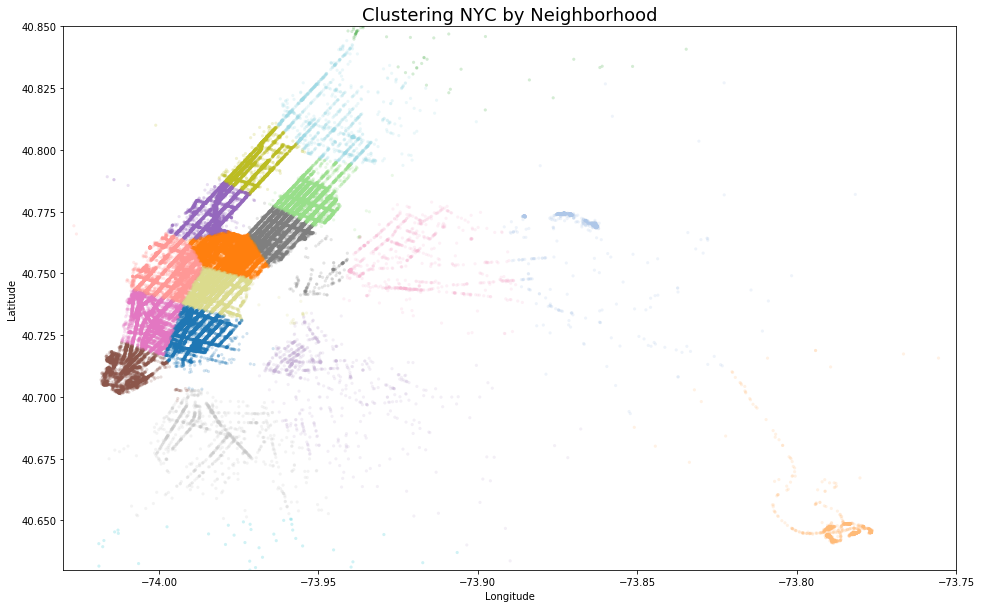

In [54]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Clustering NYC by Neighborhood', fontsize=18)
plt.show()

## 6. OSRM features

In [55]:
### EDIT THIS DESCRIPTION

In [56]:
osrm1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', 
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps']
                 )
osrm2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', 
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps']
                 )
test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps']
                              )

In [57]:
test_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id0771704,1497.1,200.2,7
1,id3274209,1427.1,141.5,2
2,id2756455,2312.3,324.6,9
3,id3684027,931.8,84.2,4
4,id3101285,2501.7,294.7,8


In [58]:
train_street_info = pd.concat((osrm1, osrm2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

# 7. Prepare Data for Modelling

- Since the evaluation metric for this competition is RMSLE and not RMSE, we must log transform our target variable
- We also need to dummify the only categorical variable: `store_and_fwd_flag`

In [59]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)

In [60]:
print(np.setdiff1d(train.columns, test.columns))

['avg_speed_h' 'avg_speed_m' 'dropoff_datetime' 'trip_duration']


In [61]:
do_not_use_for_training = ['id', 'log_trip_duration', 'trip_duration', 'dropoff_datetime', 'pickup_date', 
                           'pickup_datetime', 'pickup_weekday_name', 'date', 'avg_speed_h', 'avg_speed_m',
                          'snow depth']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].info()

We have 40 features.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 40 columns):
vendor_id                   1458644 non-null uint8
passenger_count             1458644 non-null uint8
pickup_longitude            1458644 non-null float32
pickup_latitude             1458644 non-null float32
dropoff_longitude           1458644 non-null float32
dropoff_latitude            1458644 non-null float32
store_and_fwd_flag          1458644 non-null category
pickup_pca0                 1458644 non-null float64
pickup_pca1                 1458644 non-null float64
dropoff_pca0                1458644 non-null float64
dropoff_pca1                1458644 non-null float64
distance_haversine          1458644 non-null float32
distance_dummy_manhattan    1458644 non-null float32
direction                   1458644 non-null float32
pca_manhattan               1458644 non-null float64
center_latitude             1458644 non-null float32
center_longitude     

In [62]:
X = train[feature_names].values
y = np.log(train['trip_duration'].values + 1)

In [63]:
len(X)

1458644

In [64]:
len(y)

1458644

### 7.1 K-Fold Cross Validation

In [65]:
kf = KFold(n_splits=10, random_state=1995, shuffle=True)

In [66]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [      0       1       2 ..., 1458639 1458641 1458643] TEST: [      3       7      12 ..., 1458629 1458640 1458642]
TRAIN: [      0       1       2 ..., 1458641 1458642 1458643] TEST: [     43      50      55 ..., 1458621 1458624 1458630]
TRAIN: [      0       1       2 ..., 1458641 1458642 1458643] TEST: [     22      29      42 ..., 1458628 1458635 1458636]
TRAIN: [      0       1       3 ..., 1458641 1458642 1458643] TEST: [      2       8      24 ..., 1458626 1458627 1458639]
TRAIN: [      0       1       2 ..., 1458641 1458642 1458643] TEST: [      4      21      30 ..., 1458603 1458620 1458634]
TRAIN: [      0       1       2 ..., 1458640 1458641 1458642] TEST: [     15      20      27 ..., 1458606 1458632 1458643]
TRAIN: [      0       2       3 ..., 1458641 1458642 1458643] TEST: [      1       5      19 ..., 1458631 1458633 1458638]
TRAIN: [      0       1       2 ..., 1458641 1458642 1458643] TEST: [      6      10      11 ..., 1458592 1458594 1458619]
TRAIN: [      1 

In [67]:
print(len(X_train),len(X_test),len(y_train),len(y_test))

1312780 145864 1312780 145864


### 7.2 Optimize dtypes

In [68]:
## NEED TO OPTIMIZE AGAIN 

## 8. XGBoost

In [69]:
# Set up DMatrices for XGBoost
# - A Dmatrix is simply a "data matrix" for XGBoost optimized for efficiency
# - Combining X_train, y_train into the training matrix and X_test, y_test into the validation matrix etc.
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [50]:
# xgb_pars = {'min_child_weight': 6, 
#             'eta': 0.02, 
#             'colsample_bytree': 0.8, 
#             'max_depth': 8,
#             'subsample': 0.8,
#             'lambda': 2., 
#             'nthread': -1, 
#             'booster' : 'gbtree', 
#             'silent': 1,
#             'eval_metric': 'rmse', 
#             'objective': 'reg:linear'}

In [51]:
# XGBoost Hyperparameter tuning
xgb_pars_weather = {'min_child_weight': 6, 
            'eta': 0.05, 
            'colsample_bytree': 0.8, 
            'max_depth': 8,
            'subsample': 0.8,
            'lambda': 2., 
            'nthread': -1, 
            'booster' : 'gbtree', 
            'silent': 1,
            'eval_metric': 'rmse', 
            'objective': 'reg:linear'}

In [ ]:
# THE BEST GENERALIZABLE WEATHER MODEL FOR SUBMISSION !!!
t0 = datetime.datetime.now()
model = xgb.train(xgb_pars_weather, dtrain, 1000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=10)
print('Modeling RMSLE %.5f' % model.best_score)
t1 = datetime.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

In [53]:
# # BASELINE XGBOOST MODEL (for weather comparison below)

# t0 = datetime.datetime.now()
# model = xgb.train(xgb_pars_weather, dtrain, 50, watchlist, early_stopping_rounds=10,
#       maximize=False, verbose_eval=10)
# print('Modeling RMSLE %.5f' % model.best_score)
# t1 = datetime.datetime.now()
# print('Training time: %i seconds' % (t1 - t0).seconds)

In [54]:
# # ADDING IN WEATHER FEATURES (lets see if it increases score...)

# t0 = datetime.datetime.now()
# model = xgb.train(xgb_pars_weather, dtrain, 50, watchlist, early_stopping_rounds=10,
#       maximize=False, verbose_eval=10)
# print('Modeling RMSLE %.5f' % model.best_score)
# t1 = datetime.datetime.now()
# print('Training time: %i seconds' % (t1 - t0).seconds)

In [55]:
# # THE BEST GENERALIZABLE MODEL FOR SUBMISSION (with a solid score still)

# t0 = datetime.datetime.now()
# model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
#       maximize=False, verbose_eval=10)
# print('Modeling RMSLE %.5f' % model.best_score)
# t1 = datetime.datetime.now()
# print('Training time: %i seconds' % (t1 - t0).seconds)

In [56]:
t1 = datetime.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)
print('Training time: ~%i hours' % round((t1 - t0).seconds / 3600 ))

Training time: 10326 seconds
Training time: ~3 hours


In [58]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Something is wrong :/')
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('xgb_submission-weather-2.csv', index=False)
print("Results successfully saved to csv :)")

Test shape OK.
Results successfully saved to csv :)


In [ ]:
test[['id', 'trip_duration']].to_csv('xgb_submission-weather-base.csv', index=False)